### SSIoT traffic analysis

The notebook is designed to fit my data, but it should work for also for the other IoT device.
The pcap files should first be converted into a csv file.

In [2]:
import pandas as pd
import sys
from os import listdir
from os.path import isfile, join
import re
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from pandas.plotting import autocorrelation_plot
import numpy as np


In [104]:
path_miLamp = "C:\\Users\\Raphael\\github\\Security-Services-for-IoT\\Final-Project\\pcap\\processed\\MiLamp\\"
path_smartPlug = "C:\\Users\Raphael\\github\\Security-Services-for-IoT\\Final-Project\\pcap\\processed\\Smart_Plug-HS100\\new_measurements_ht_csv\\"
path_smartPlug_wifi = "C:\\Users\Raphael\\github\\Security-Services-for-IoT\\Final-Project\\pcap\\processed\\Smart_Plug-HS100\\new_measurements_wifi_csv\\"


filenames_miLamp = [f for f in listdir(path_miLamp) if isfile(join(path_miLamp, f))]
filenames_smartPlug = [f for f in listdir(path_smartPlug) if isfile(join(path_smartPlug, f))]
filenames_smartPlug_wifi = [f for f in listdir(path_smartPlug_wifi) if isfile(join(path_smartPlug_wifi, f))]

exclude= ["MiLampStartUp.csv", "MiLampStartUp2.csv", "MiLampIdle.csv"]

### Load files and label them accordinngly
Each csv file in the given directory, except the ones in the "exclude" variable, will be loaded and added to one dataframe. 
The labels correspond the the filename.

In [50]:
# read files and label them accordingly
def read_and_label(filenames,exclude, path):
    sametest = []
    checked = set()
    for file in filenames:
        if file in exclude:
            continue
        same = []
        file = file.split(".")[0]
        for name in filenames:
            if file in name and file != name:
                if name not in checked:
                    #name = name.split(".")[0]
                    same.append(name)
                    checked.add(name)
        if len(same) > 0:
            sametest.append(same)
    df = pd.DataFrame()
    for files in sametest:
        tm = pd.DataFrame()
        for i in range(len(files)):
            tm = pd.concat([tm, pd.read_csv(path + files[i], header=0)],ignore_index=False)
        tm["label"] = str(files[0].split(".")[0])
        df = pd.concat([df,tm], ignore_index=False)
    df = df.reset_index(drop=True)
    return df

### The recode_time might need to be changed depending on the format of the timestamp

In [51]:
# reformat the timestamp
def recode_time(df):
    for i in range(df.shape[0]):
        date = str(df.at[i,"frame.time"]).split(" ")
        if len(date) == 7:
            df.at[i,"frame.time"] = pd.Timestamp(str(df.at[i,"frame.time"]).split(" ")[4])
        else:
            df.at[i,"frame.time"] = pd.Timestamp(str(df.at[i,"frame.time"]).split(" ")[3])

In [52]:
# drop specific rows
def drop_it(df, column, value):
    df = df.drop(df[(df[column[0]] != value) | (df[column[1]] != value)].index)
    return df

In [53]:
# plots every feature of the given df, except the excluded ones, m are rows and n are the columns of the plot
def plot_stuff(df, exclude,m,n):
    c = 0
    r = 0
    fig, axs = plt.subplots(m,n, sharex=False, figsize=(30,12))
    for column in df:
        if column in exclude:
            continue
        axs[r, c%n] = df[column].value_counts().plot(kind="barh", ax=axs[r, c%n], title=column)
        #axs[r, c%n].set_title(column)
        # set individual bar lables using above list
        for i in axs[r, c%n].patches:
            # get_width pulls left or right; get_y pushes up or down
            axs[r, c%n].text(i.get_width()+.1, i.get_y()+.2, str(round((i.get_width()), 2)), fontsize=10, color='dimgrey')
        c += 1 
        r += n == c /(r + 1)
    plt.show()
    plt.clf
    print("Info for ip protocol: 2:{}, 6: {}, 17: {}".format("IGMP (Internet Group Management Protocol)", "TCP", "UDP"))

In [54]:
# plots the autocorrelation of a given df
def plot_autocorr(df):
    c = 0
    r = 0
    labels = df.label.value_counts().index.tolist()
    m = 4
    n = len(labels)//m +1
    fig, axs = plt.subplots(m,n, sharex=False, figsize=(30,12))
    for label in labels:
        axs[r, c%n] = autocorrelation_plot(df["data.len"].loc[df.label==label], ax=axs[r, c%n])
        axs[r, c%n].set_title(label)
        c += 1 
        r += n == c /(r + 1)
    plt.show()
    plt.clf

In [86]:
# plots the different data lengths and their occurence, Occurence should be computed before that
def plot_len_occ(df, proto):
    c = 0
    r = 0
    col = "data.len"
    if proto == "tcp":
        col = "tcp.len"
    labels = df.label.value_counts().index.tolist()
    m = 4
    n = len(labels)//m +1
    fig, axs = plt.subplots(m,n, sharex=False, figsize=(30,15))
    for label in labels:
        plot_label =  np.array(df[col].loc[df.label==label].value_counts().index.tolist())
        data = []
        for val in plot_label:
            data.append(df["len_count"].loc[(df.label==label) & (df[col] == val)].iloc[0])
        x = np.arange(len(plot_label))
        #if len(data) > len(plot_label):
            #data = data[0:len(plot_label)]
        #print(label)
        #print(data)
        #print(plot_label)
        axs[r, c%n].bar(x, data, 0.5)
        axs[r, c%n].set_title(label)
        axs[r, c%n].set_xticklabels(plot_label)
        axs[r, c%n].set_xticks(x)

        c += 1 
        r += n == c /(r + 1)
    plt.show()
    plt.clf

In [56]:
# Function to remove background traffic
# input df: dataframe which should be modified
# input relevant: list of relevant host IP addresses
def removeBack(df, relevant, mac):
  print("{} total flows".format(df.shape[0]))
  result = df.loc[(df["ip.src"] == relevant[0]) | (df["ip.dst"] == relevant[0])]
  for i in range(1,len(relevant)):
    result = pd.concat([result,df.loc[(df["ip.src"] == relevant[i]) | (df["ip.dst"] == relevant[i])]], ignore_index =True)
  result = pd.concat([result,df.loc[(df["eth.src"] == mac) | (df["eth.dst"] == mac)]], ignore_index =True)
  result = result.drop_duplicates()
  print("{} flows from relevant hosts".format(result.shape[0]))
  result = result.reset_index(drop=True)
  return result

In [231]:
df_ml = read_and_label(filenames_miLamp, exclude, path_miLamp)
mi_idle = pd.read_csv(path_miLamp + "MiLampIdle.csv", header=0)
df_sp = read_and_label(filenames_smartPlug, [], path_smartPlug)
df_sp_w = read_and_label(filenames_smartPlug_wifi, [], path_smartPlug_wifi)
recode_time(df_ml)
recode_time(mi_idle)
recode_time(df_sp)
recode_time(df_sp_w)

In [232]:
# show available labels for MiLamp:
df_ml.label.value_counts()

MiLampDecreaseBrightnessInApp    282
MiLampIncreaseTempInApp          229
MiLampDecreaseTempInApp          196
MiLampIncreaseBrightnessInApp    181
MiLampChildMode                   65
MiLampPushTurnButtonLeft          52
MiLampAdjustTempInApp             41
MiLampTurnButtonLeft              41
MiLampTurnButtonRight             36
MiLampTurnOnFocusModeApp          30
MiLampPushTurnButtonRight         27
MiLampDoubleTabButton             26
MiLampAdjustBrightnessInApp       24
MiLampOpenApp                     20
MiLampTurnOffinApp                15
MiLampTurnOninApp                 15
MiLampTurnOnPCModeApp             15
MiLampTurnOffFocusModeApp         14
MiLampTurnOnReadingModeApp        13
MiLampPressOnButtonToTurnOn       13
MiLampOpenSettings                11
MiLampPressOnButtonToTurnOff      10
Name: label, dtype: int64

In [233]:
# show available labels for SmartPlug:
df_sp.label.value_counts()

set_up_device                        1055
enter_to_the_app                      177
leave_the_app_open_with_no_action     111
turn_off                              107
test_on_off_using_wifi                 69
turn_on                                69
leave_1_min_the_page_device            42
enter_to_run_time                      25
enter_to_the_device_from_app           17
go_to_settings_device                  13
set_away_mode                           7
create_schedule                         3
set_off_away_mode                       2
Name: label, dtype: int64

In [234]:
df_sp.head()

,frame.number,frame.time,eth.src,eth.dst,ip.src,ip.dst,ip.proto,data.data,data.len,udp.srcport,udp.dstport,udp.length,eth.addr.oui_resolved,tcp.srcport,tcp.dstport,tcp.len,label
0,1,2020-06-19 10:26:00.240304,d0:37:45:53:9a:9d,a8:9c:ed:52:b4:4b,172.217.17.130,192.168.2.3,6.0,NaN,NaN,NaN,NaN,NaN,Xiaomi Communications Co Ltd,443.0,48504.0,580.0,create_schedule
1,2,2020-06-19 10:26:10.526395,d0:37:45:53:9a:9d,a8:9c:ed:52:b4:4b,161.117.71.89,192.168.2.3,6.0,NaN,NaN,NaN,NaN,NaN,Xiaomi Communications Co Ltd,443.0,49400.0,31.0,create_schedule
2,3,2020-06-19 10:26:10.526475,d0:37:45:53:9a:9d,a8:9c:ed:52:b4:4b,161.117.71.89,192.168.2.3,6.0,NaN,NaN,NaN,NaN,NaN,Xiaomi Communications Co Ltd,443.0,49400.0,0.0,create_schedule
3,1,2020-06-19 10:28:32.656580,d0:37:45:53:9a:9d,a8:9c:ed:52:b4:4b,142.250.27.188,192.168.2.3,6.0,NaN,NaN,NaN,NaN,NaN,Xiaomi Communications Co Ltd,5228.0,38594.0,269.0,enter_to_run_time
4,2,2020-06-19 10:28:33.235659,d0:37:45:53:9a:9d,a8:9c:ed:52:b4:4b,216.58.211.101,192.168.2.3,6.0,NaN,NaN,NaN,NaN,NaN,Xiaomi Communications Co Ltd,443.0,38402.0,0.0,enter_to_run_time


In [235]:
df_sp_w.tail()

,frame.number,frame.time,eth.src,eth.dst,ip.src,ip.dst,ip.proto,data.data,data.len,udp.srcport,udp.dstport,udp.length,eth.addr.oui_resolved,tcp.srcport,tcp.dstport,tcp.len,label
47604,3553,2020-06-19 10:00:06.257447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turn_on
47605,3554,2020-06-19 10:00:06.261769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turn_on
47606,3555,2020-06-19 10:00:06.265660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turn_on
47607,3556,2020-06-19 10:00:06.276387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turn_on
47608,3557,2020-06-19 10:00:06.276436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,turn_on


In [236]:
df_ml.head()

,frame.number,frame.time,eth.src,eth.dst,ip.src,ip.dst,ip.proto,data.data,data.len,udp.srcport,udp.dstport,udp.length,eth.addr.oui_resolved,tcp.srcport,tcp.dstport,tcp.len,label
0,1,2020-06-19 17:27:27.884190,46:85:00:12:35:54,40:31:3c:d3:23:d4,3.124.122.199,192.168.137.47,17.0,21310070000000000721ae555edbb5de8052a323ad33df...,112.0,8053.0,54321.0,120.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,MiLampAdjustBrightnessInApp
1,2,2020-06-19 17:27:27.954667,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,3.124.122.199,17.0,21310040000000000721ae555edbb5df7efea2fd7132c2...,64.0,54321.0,8053.0,72.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,MiLampAdjustBrightnessInApp
2,3,2020-06-19 17:27:27.959515,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,3.124.122.199,17.0,21310060000000000721ae555edbb5df44b21b3ee0d9d9...,96.0,54321.0,8053.0,104.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,MiLampAdjustBrightnessInApp
3,4,2020-06-19 17:27:27.996886,46:85:00:12:35:54,40:31:3c:d3:23:d4,3.124.122.199,192.168.137.47,17.0,21310040000000000721ae555edbb5dfb22f2601dc3317...,64.0,8053.0,54321.0,72.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,MiLampAdjustBrightnessInApp
4,5,2020-06-19 17:27:28.805023,46:85:00:12:35:54,40:31:3c:d3:23:d4,3.124.122.199,192.168.137.47,17.0,21310070000000000721ae555edbb5df57f80dc3b3d676...,112.0,8053.0,54321.0,120.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,MiLampAdjustBrightnessInApp


In [237]:
mi_idle.head()

,frame.number,frame.time,eth.src,eth.dst,ip.src,ip.dst,ip.proto,data.data,data.len,udp.srcport,udp.dstport,udp.length,eth.addr.oui_resolved,tcp.srcport,tcp.dstport,tcp.len
0,1,2020-06-19 17:42:39.441218,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,3.124.122.199,17.0,21310020000000000721ae555edbb96ee4f8a3b1fccc78...,32.0,54321.0,8053.0,40.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN
1,2,2020-06-19 17:42:39.480953,46:85:00:12:35:54,40:31:3c:d3:23:d4,3.124.122.199,192.168.137.47,17.0,21310020000000000721ae555edbb96ee4f8a3b1fccc78...,32.0,8053.0,54321.0,40.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN
2,3,2020-06-19 17:42:46.441862,46:85:00:12:35:54,ff:ff:ff:ff:ff:ff,192.168.137.1,192.168.137.255,17.0,53706f745564703027570d3f3d27d128000100044895c2...,44.0,57621.0,57621.0,52.0,NaN,NaN,NaN,NaN
3,4,2020-06-19 17:42:50.190389,46:85:00:12:35:54,01:00:5e:00:00:fb,192.168.137.1,224.0.0.251,17.0,NaN,NaN,5353.0,5353.0,53.0,NaN,NaN,NaN,NaN
4,5,2020-06-19 17:42:52.170941,46:85:00:12:35:54,01:00:5e:7f:ff:fa,192.168.137.1,239.255.255.250,17.0,NaN,NaN,56640.0,1900.0,134.0,NaN,NaN,NaN,NaN


### Clean the data from unwanted traffic


In [238]:
lampIps = ["192.168.137.44", "192.168.137.47"]
lampMac = "40:31:3c:d3:23:d4"
plugIps = "192.168.1.16"
plugMac = "1c:3b:f3:4d:36:04"

In [239]:
# only keep traffic from and to the IP addresses
df_sp = removeBack(df_sp,plugIps,plugMac)
mi_idle = removeBack(mi_idle,lampIps,lampMac)
df_sp_w = removeBack(df_sp_w,plugIps,plugMac)
df_ml = removeBack(df_ml,lampIps,lampMac)

1697 total flows
237 flows from relevant hosts
167618 total flows
3276 flows from relevant hosts
47609 total flows
0 flows from relevant hosts
1356 total flows
1235 flows from relevant hosts


### Remove columns which only have nan values

In [240]:
df_sp= df_sp.dropna(axis=1, how='all')
mi_idle= mi_idle.dropna(axis=1, how='all')
df_sp_w= df_sp_w.dropna(axis=1, how='all')
df_ml= df_ml.dropna(axis=1, how='all')

### Remove messages regular check messages
There are some messages between the server and the lamp which are sent regulary and I think they dont belong to the traffic caused by the user interaction

In [241]:
df_ml = df_ml.drop(df_ml[df_ml["data.len"] == 32].index)

### Plot the features

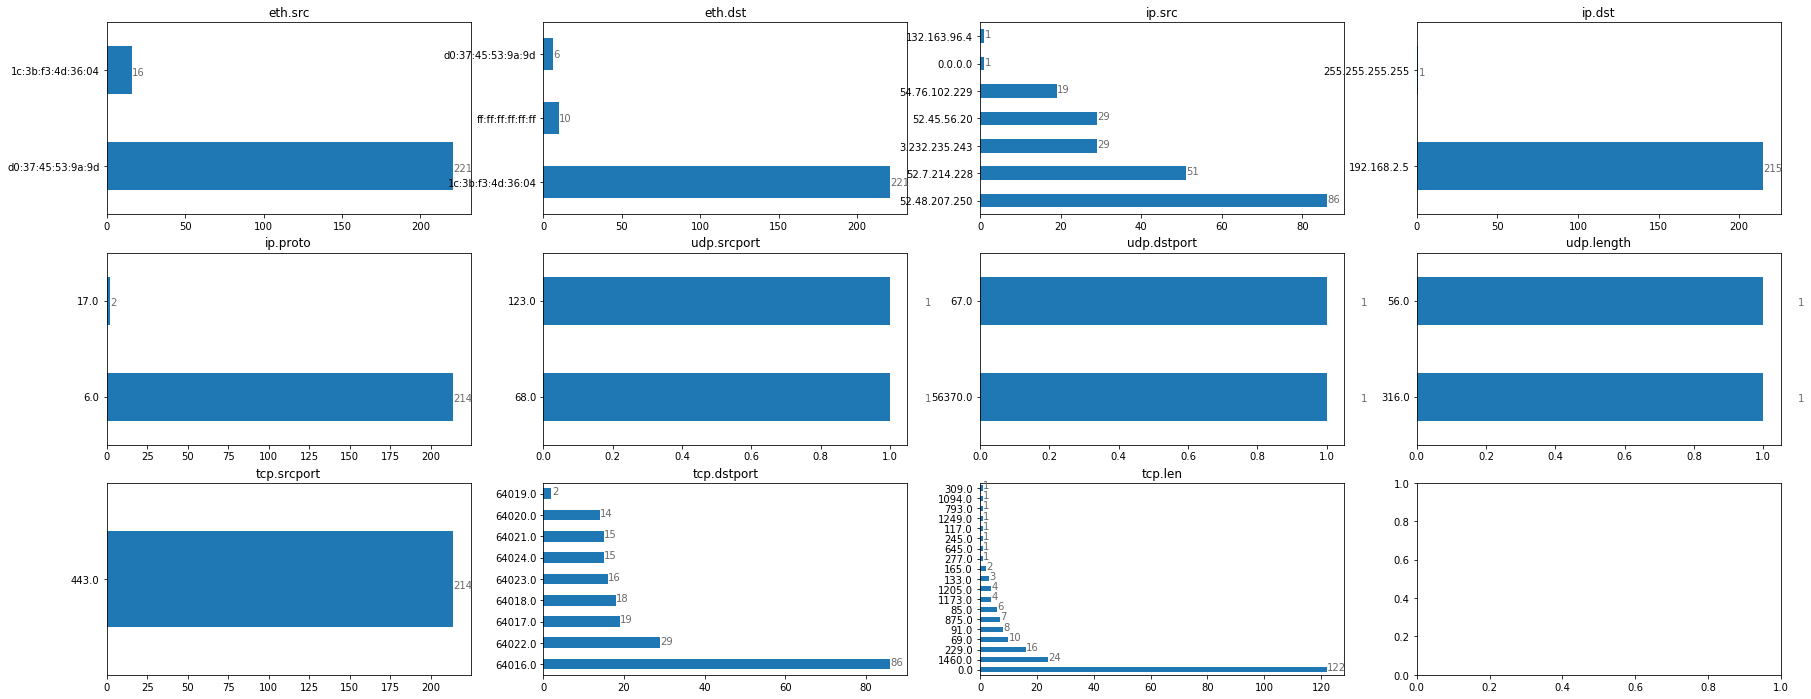

Info for ip protocol: 2:IGMP (Internet Group Management Protocol), 6: TCP, 17: UDP


In [251]:
#features to exclude
no_interest = ["frame.number", "frame.time","data.data", "eth.addr.oui_resolved", "label"]
#plot smartplug
plot_stuff(df_sp,no_interest,3,4)

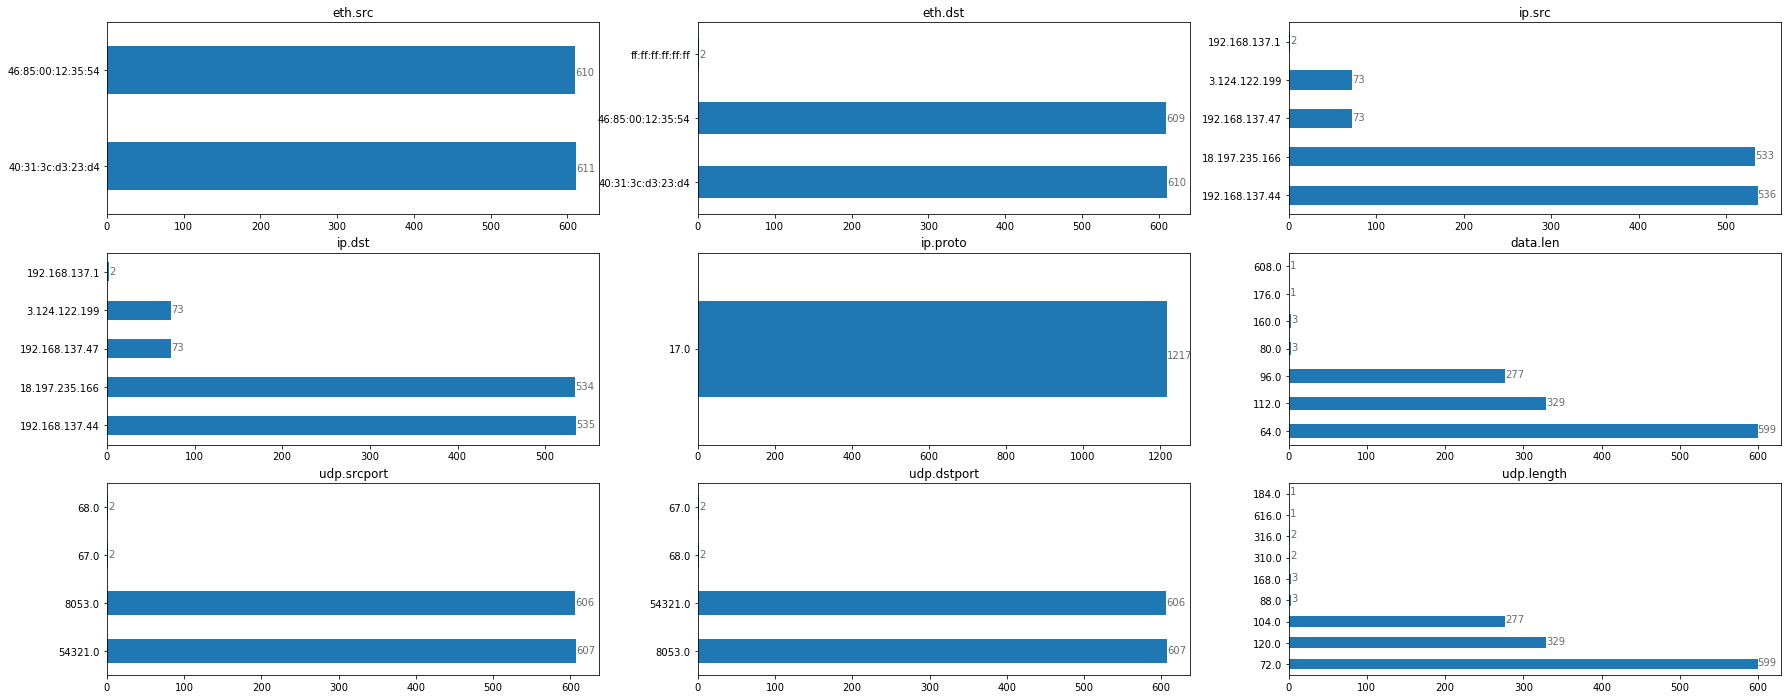

Info for ip protocol: 2:IGMP (Internet Group Management Protocol), 6: TCP, 17: UDP


In [252]:
#plot Mi Lamp
plot_stuff(df_ml,no_interest,3,3)

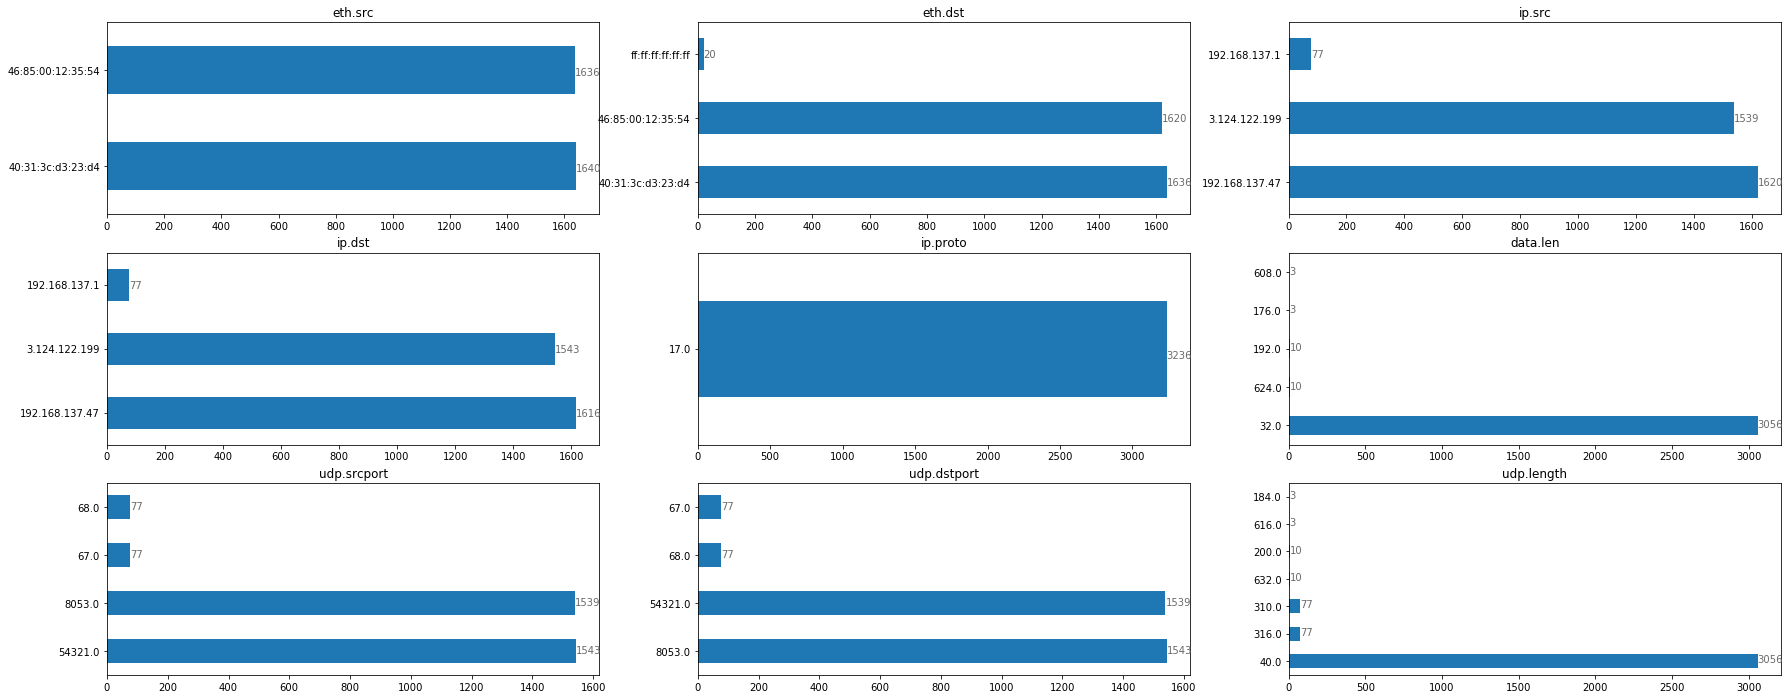

Info for ip protocol: 2:IGMP (Internet Group Management Protocol), 6: TCP, 17: UDP


In [253]:
#plot idle milamp
mi_idle["label"]="idle"
plot_stuff(mi_idle,no_interest,3,3)

In [70]:
lendata = df_ml["udp.length"].groupby(df_ml["label"]).value_counts()#.plot(kind="barh", figsize=(5,12)

In [254]:
# calculate the occurence of each packet data length of a measurement as a ration of its occurence/total number of packets of in a measurement
df_ml["len_count"] = 0
available_labels = df_ml["label"].value_counts().index.tolist()
for label in available_labels:
    available_lens = df_ml.loc[df_ml["label"] == label]["data.len"].value_counts().index.tolist()
    for length in available_lens:
        l = df_ml["data.len"].loc[(df_ml["label"] == label) & (df_ml["data.len"] == length)]
        df_ml["len_count"].loc[(df_ml["label"] == label) & (df_ml["data.len"] == length)] = l.shape[0]
    df_ml["len_count"].loc[(df_ml["label"] == label)] = df_ml["len_count"].loc[(df_ml["label"] == label)] / df_ml.loc[(df_ml["label"] == label)].shape[0]

In [255]:
# calculate the occurence of each packet data length of a measurement as a ration of its occurence/total number of packets of in a measurement
df_sp["len_count"] = 0
available_labels = df_sp["label"].value_counts().index.tolist()
for label in available_labels:
    available_lens = df_sp.loc[df_sp["label"] == label]["tcp.len"].value_counts().index.tolist()
    for length in available_lens:
        l = df_sp["tcp.len"].loc[(df_sp["label"] == label) & (df_sp["tcp.len"] == length)]
        df_sp["len_count"].loc[(df_sp["label"] == label) & (df_sp["tcp.len"] == length)] = l.shape[0]
    df_sp["len_count"].loc[(df_sp["label"] == label)] = df_sp["len_count"].loc[(df_sp["label"] == label)] / df_sp.loc[(df_sp["label"] == label)].shape[0]

In [256]:
# calculate the occurence of each packet data length of a measurement as a ration of its occurence/total number of packets of in a measurement
mi_idle["len_count"] = 0
available_labels = mi_idle["label"].value_counts().index.tolist()
for label in available_labels:
    available_lens = mi_idle.loc[mi_idle["label"] == label]["data.len"].value_counts().index.tolist()
    for length in available_lens:
        l = mi_idle["data.len"].loc[(mi_idle["label"] == label) & (mi_idle["data.len"] == length)]
        mi_idle["len_count"].loc[(mi_idle["label"] == label) & (mi_idle["data.len"] == length)] = l.shape[0]
    mi_idle["len_count"].loc[(mi_idle["label"] == label)] = mi_idle["len_count"].loc[(mi_idle["label"] == label)] / mi_idle.loc[(mi_idle["label"] == label)].shape[0]

In [257]:
#plot variant 1
#df_ml["len_count"].groupby([df_ml["label"], df_ml["data.len"]]).value_counts().plot(kind="barh", figsize=(6,15))
#plt.show()

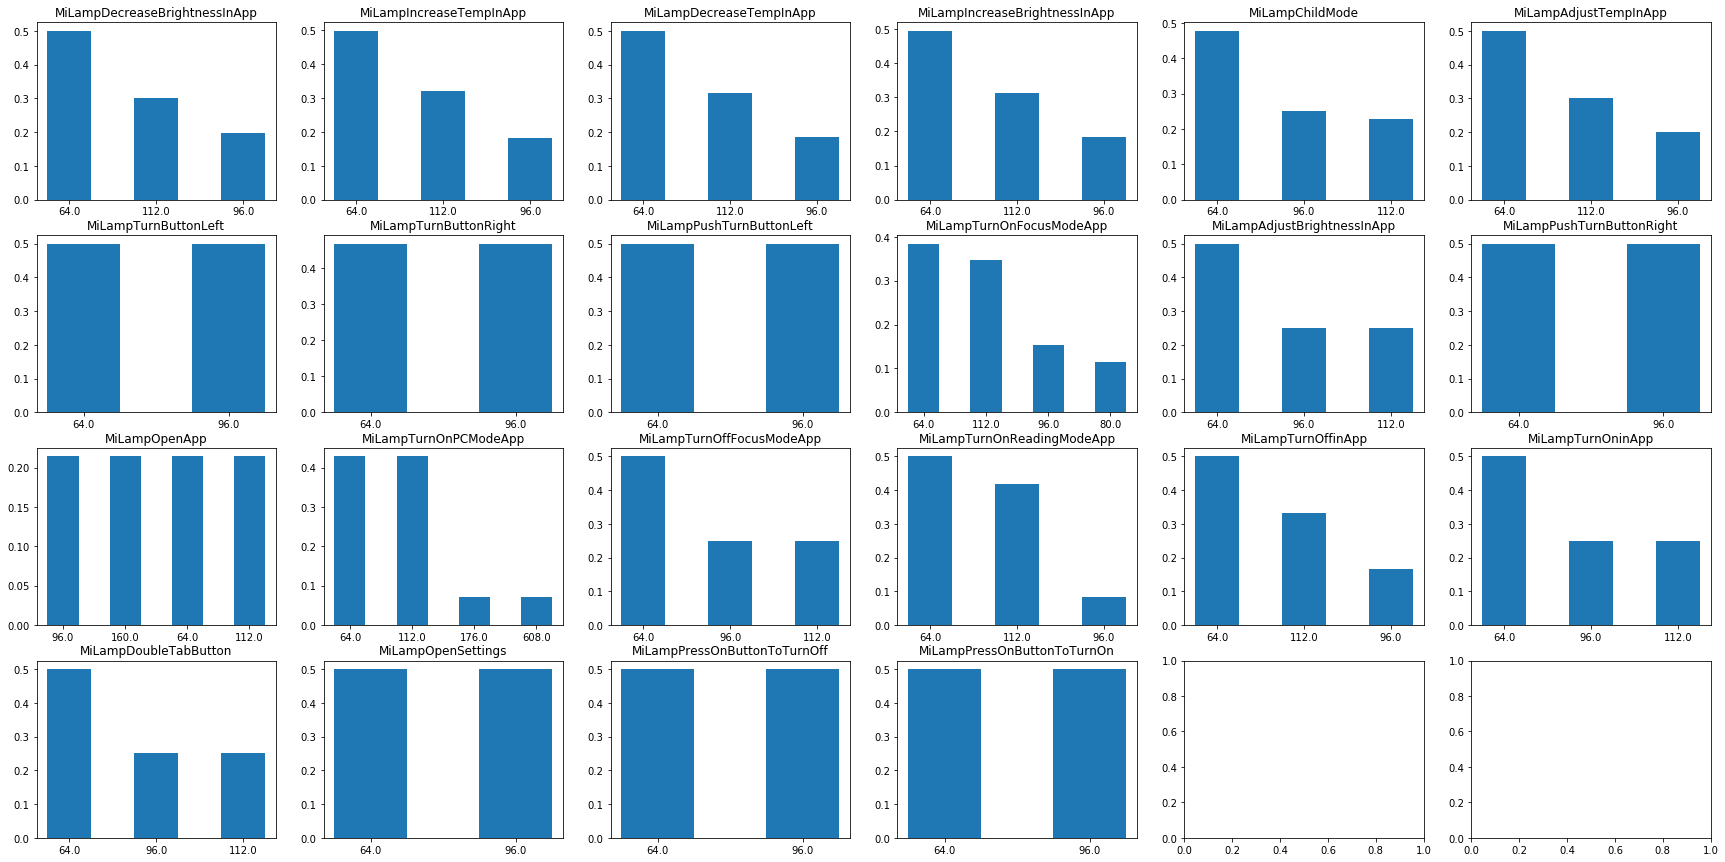

In [258]:
#plot variant 2  and remoce idle messages
plot_len_occ(df_ml,"udp")

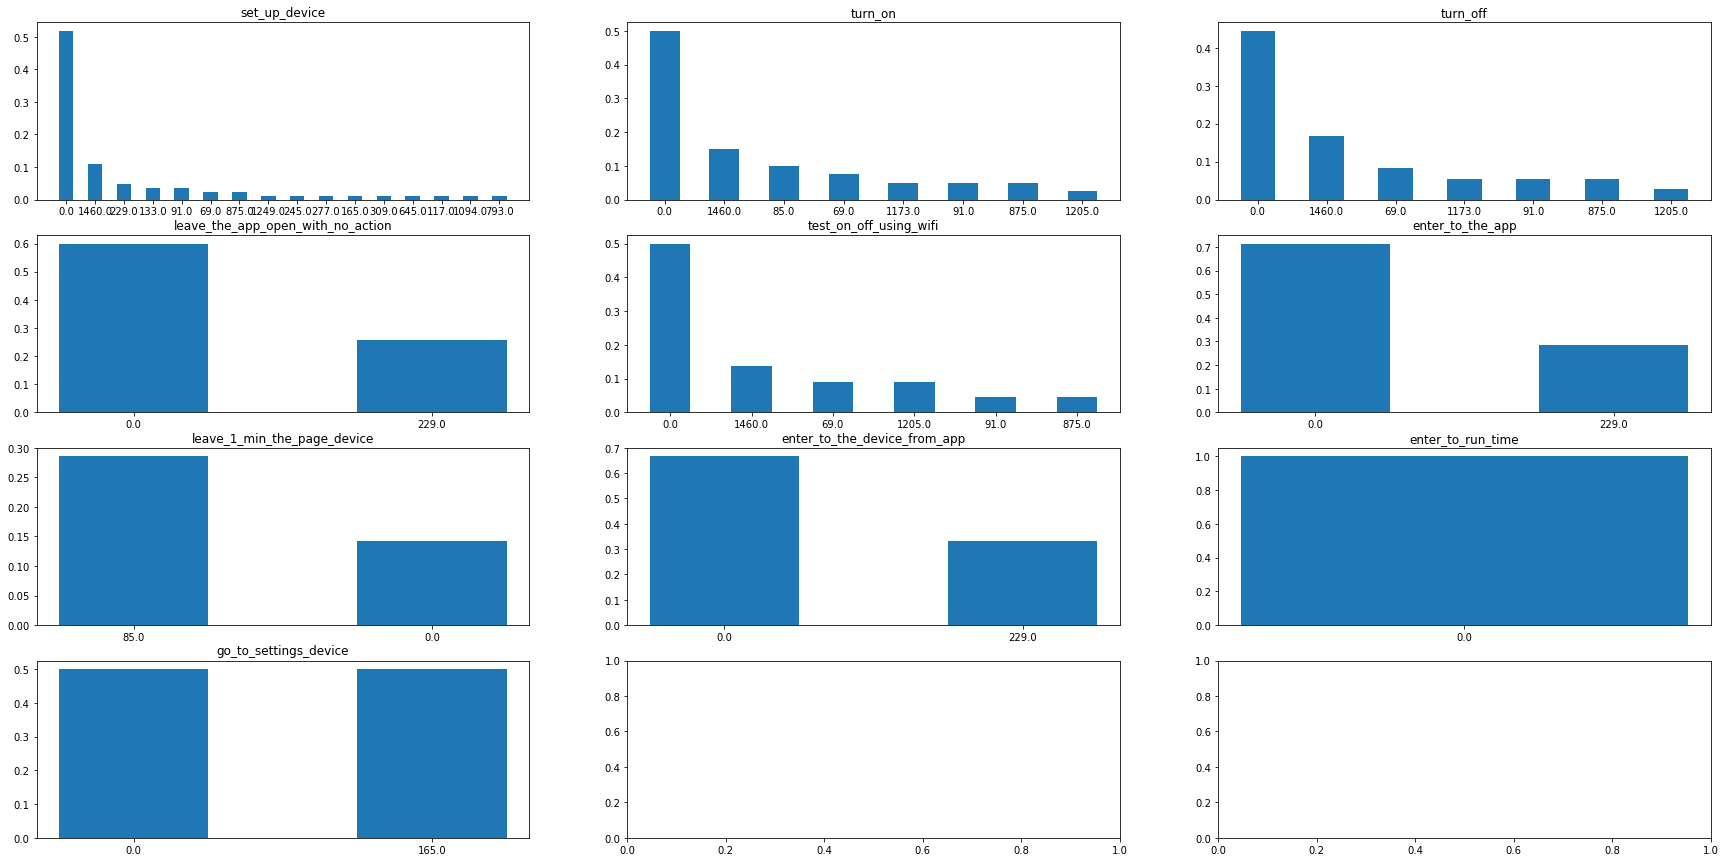

In [259]:
#plot variant 2
plot_len_occ(df_sp,"tcp")

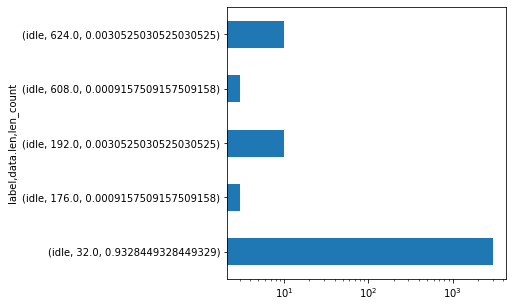

In [260]:
#plot variant 1
mi_idle["len_count"].groupby([mi_idle["label"], mi_idle["data.len"]]).value_counts().plot(kind="barh", figsize=(5,5),logx=True)
plt.show()

In [220]:
mi_idle["ip.dst"].loc[mi_idle["udp.dstport"] == 67]

14      192.168.137.1
54      192.168.137.1
96      192.168.137.1
138     192.168.137.1
180     192.168.137.1
            ...      
3044    192.168.137.1
3086    192.168.137.1
3130    192.168.137.1
3172    192.168.137.1
3214    192.168.137.1
Name: ip.dst, Length: 77, dtype: object

### Find out traffic pattern of the IoT device when there is no user interaction

C:\Users\Raphael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  


<StemContainer object of 3 artists>

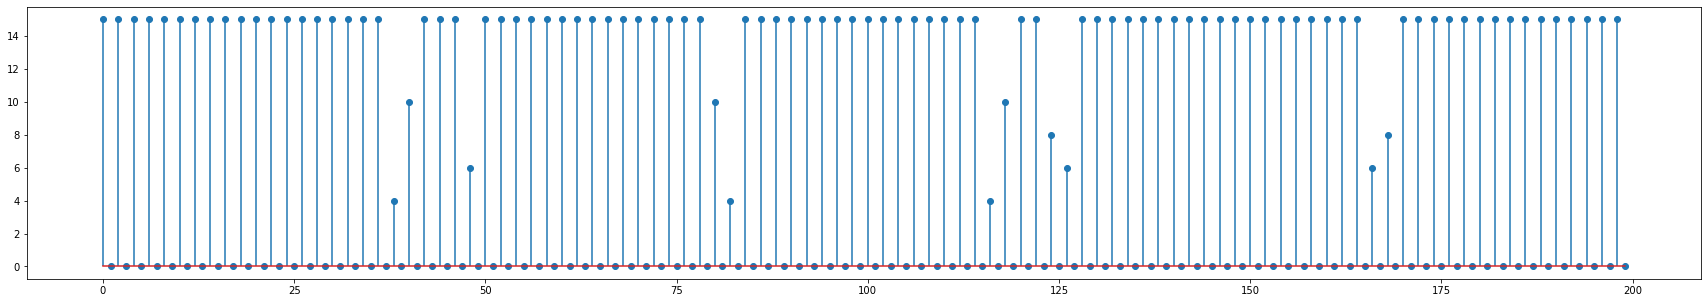

In [216]:
# Figure out if there are messages send regularly when the lamp is in idle mode
mi_idle['delta'] = (mi_idle['frame.time']-mi_idle['frame.time'].shift()).fillna(0)
mi_idle['ans'] = mi_idle['delta'].apply(lambda x: x  / np.timedelta64(1,'s')).astype('int64') % (24*60)
frame = mi_idle['ans'].iloc[100:300]
x = np.arange(frame.shape[0])
plt.figure(figsize=(30,5))
plt.stem(x,frame, use_line_collection=True)


In [217]:
#show the outliers
mi_idle.iloc[100:300].loc[(mi_idle.ans > 0) & (mi_idle.ans < 15)]

,frame.number,frame.time,eth.src,eth.dst,ip.src,ip.dst,ip.proto,data.data,data.len,udp.srcport,udp.dstport,udp.length,eth.addr.oui_resolved,tcp.srcport,tcp.dstport,tcp.len,label,len_count,delta,ans
138,302,2020-06-19 17:59:09.966303,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,192.168.137.1,17.0,NaN,NaN,68.0,67.0,316.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,idle,0.000000,00:00:04.352814,4
140,305,2020-06-19 17:59:20.883100,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,3.124.122.199,17.0,21310020000000000721ae555edbbd57bd344ebb846ede...,32.0,54321.0,8053.0,40.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,idle,0.932845,00:00:10.907079,10
148,318,2020-06-19 18:00:12.600414,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,3.124.122.199,17.0,21310260000000000721ae555edbbd8b204848628b6605...,608.0,54321.0,8053.0,616.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,idle,0.000916,00:00:06.467480,6
180,370,2020-06-19 18:04:09.961672,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,192.168.137.1,17.0,NaN,NaN,68.0,67.0,316.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,idle,0.000000,00:00:10.659618,10
182,372,2020-06-19 18:04:14.319513,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,3.124.122.199,17.0,21310020000000000721ae555edbbe7d27c27bbf0616e9...,32.0,54321.0,8053.0,40.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,idle,0.932845,00:00:04.348371,4
216,1041,2020-06-19 18:08:20.704172,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,3.124.122.199,17.0,21310020ffffffffffffffff5edbbf73000000000721ae...,32.0,54321.0,8053.0,40.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,idle,0.932845,00:00:04.576808,4
218,1058,2020-06-19 18:08:31.132302,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,3.124.122.199,17.0,21310020000000000721ae555edbbf7e83f81851107367...,32.0,54321.0,8053.0,40.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,idle,0.932845,00:00:10.396496,10
224,1772,2020-06-19 18:09:09.706247,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,192.168.137.1,17.0,NaN,NaN,68.0,67.0,316.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,idle,0.000000,00:00:08.418625,8
226,2398,2020-06-19 18:09:16.305829,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,3.124.122.199,17.0,21310020000000000721ae555edbbfab20fc5bbad2a700...,32.0,54321.0,8053.0,40.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,idle,0.932845,00:00:06.583265,6
266,10332,2020-06-19 18:14:09.581446,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.47,192.168.137.1,17.0,NaN,NaN,68.0,67.0,316.0,"XIAOMI Electronics,CO.,LTD",NaN,NaN,NaN,idle,0.000000,00:00:06.617385,6


<StemContainer object of 3 artists>

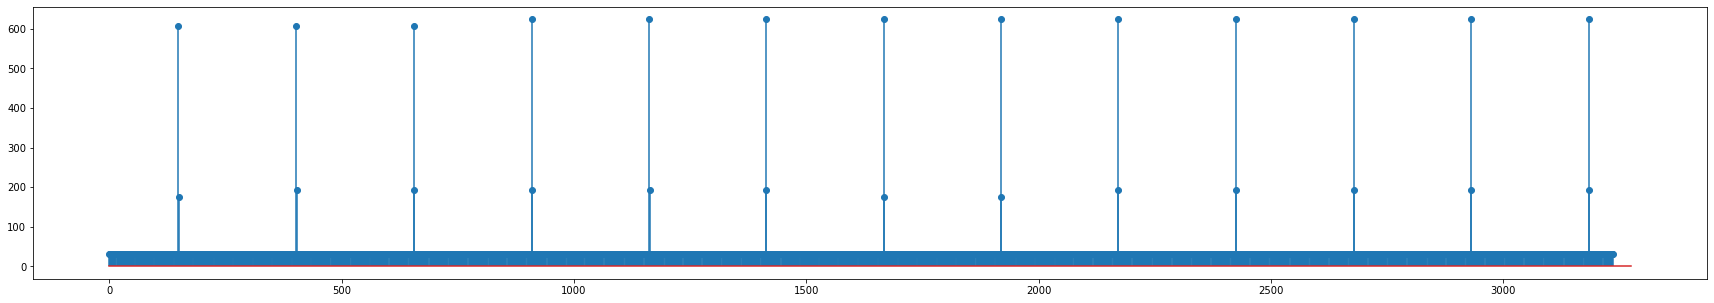

In [250]:
# Figure out if there are messages send regularly when the lamp is in idle mode
frame = mi_idle['data.len'].iloc[:4000]
x = np.arange(frame.shape[0])
plt.figure(figsize=(30,5))
plt.stem(x,frame, use_line_collection=True)

In [117]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier


In [126]:
x = df_ml.drop(columns=["frame.number", 'eth.addr.oui_resolved', "frame.time", "ip.proto"])
x = x.fillna("0")
#Function to encode given features
# input df: dataframe which should be modified
# input features: features that should be encoded
def encode_feature(df, feature):
  feature_enc = LabelEncoder()
  feature_enc.fit(df[feature].to_numpy().astype(str))
  df[feature] = feature_enc.transform(df[feature])

features = ["eth.src", "eth.dst", "ip.src", "ip.dst", "label", "data.data"]

for feat in features:
    encode_feature(x,feat)
y = x["label"]
x = x.drop(columns=["label"])
#x=x["data.data"]
x = x.reset_index(drop=True)

In [127]:
x.head()

,eth.src,eth.dst,ip.src,ip.dst,data.data,data.len,udp.srcport,udp.dstport,udp.length,tcp.srcport,tcp.dstport,tcp.len,len_count
0,0,1,3,1,6,32,54321,8053,40,0,0,0,0.043478
1,1,0,1,3,6,32,8053,54321,40,0,0,0,0.043478
2,1,0,1,3,1206,112,8053,54321,120,0,0,0,0.217391
3,0,1,3,1,587,64,54321,8053,72,0,0,0,0.456522
4,1,0,1,3,1207,112,8053,54321,120,0,0,0,0.217391


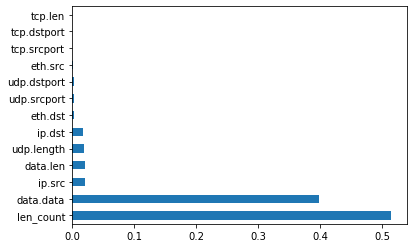

In [128]:
# Show the relevance of each feature
model = ExtraTreesClassifier()
model.fit(x,y.astype('int').ravel())
# visualize the importance of the features
imp_features = pd.Series(model.feature_importances_, index=x.columns)
imp_features.nlargest(len(x.columns.tolist())).plot(kind='barh')
plt.show()

In [141]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [142]:
# set up the classifier
# white-box classifier
model_wb = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)

prob_wb = model_wb.predict_proba(X_train)
print(model_wb.score(X_test,y_test))

# train black-box
model_bb = ComplementNB().fit(X_train,y_train)
prob_bb = model_bb.predict_proba(X_train)

print(model_bb.score(X_test,y_test))

0.875
0.12990196078431374
